In [1]:
from plot import visualisation_plot, prepare_data, to_table, save_plot

In [2]:
%matplotlib widget

In [3]:
list_dict = prepare_data.get_list_dict()

# I. Visualisation plot

In [4]:
vplot = visualisation_plot.VisualisationPlot(list_dict)

## 1) Scatter plot in 3D

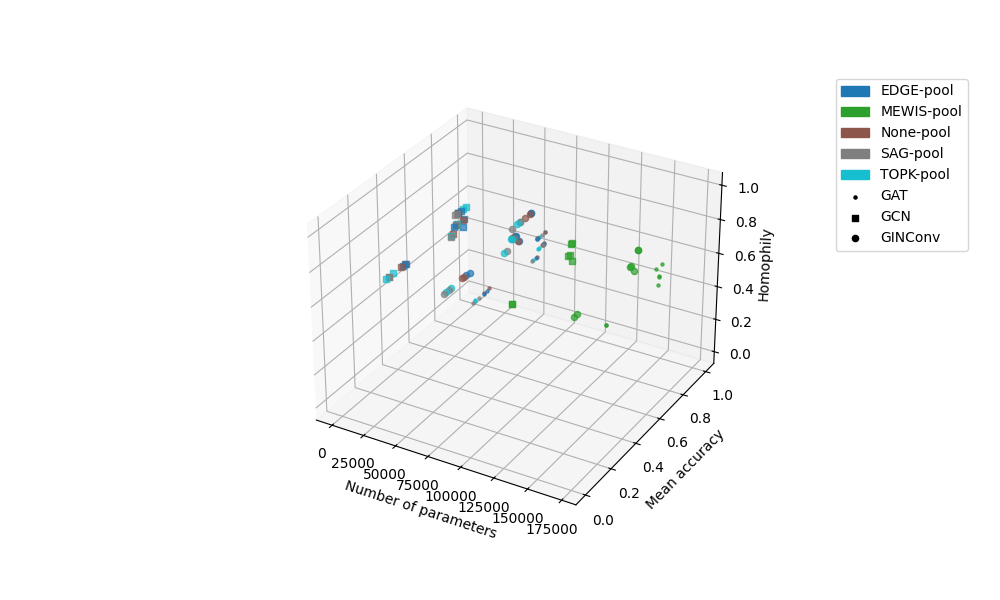

In [5]:
vplot.plot_from_dict(alpha=.7);

## 2) Pairplot

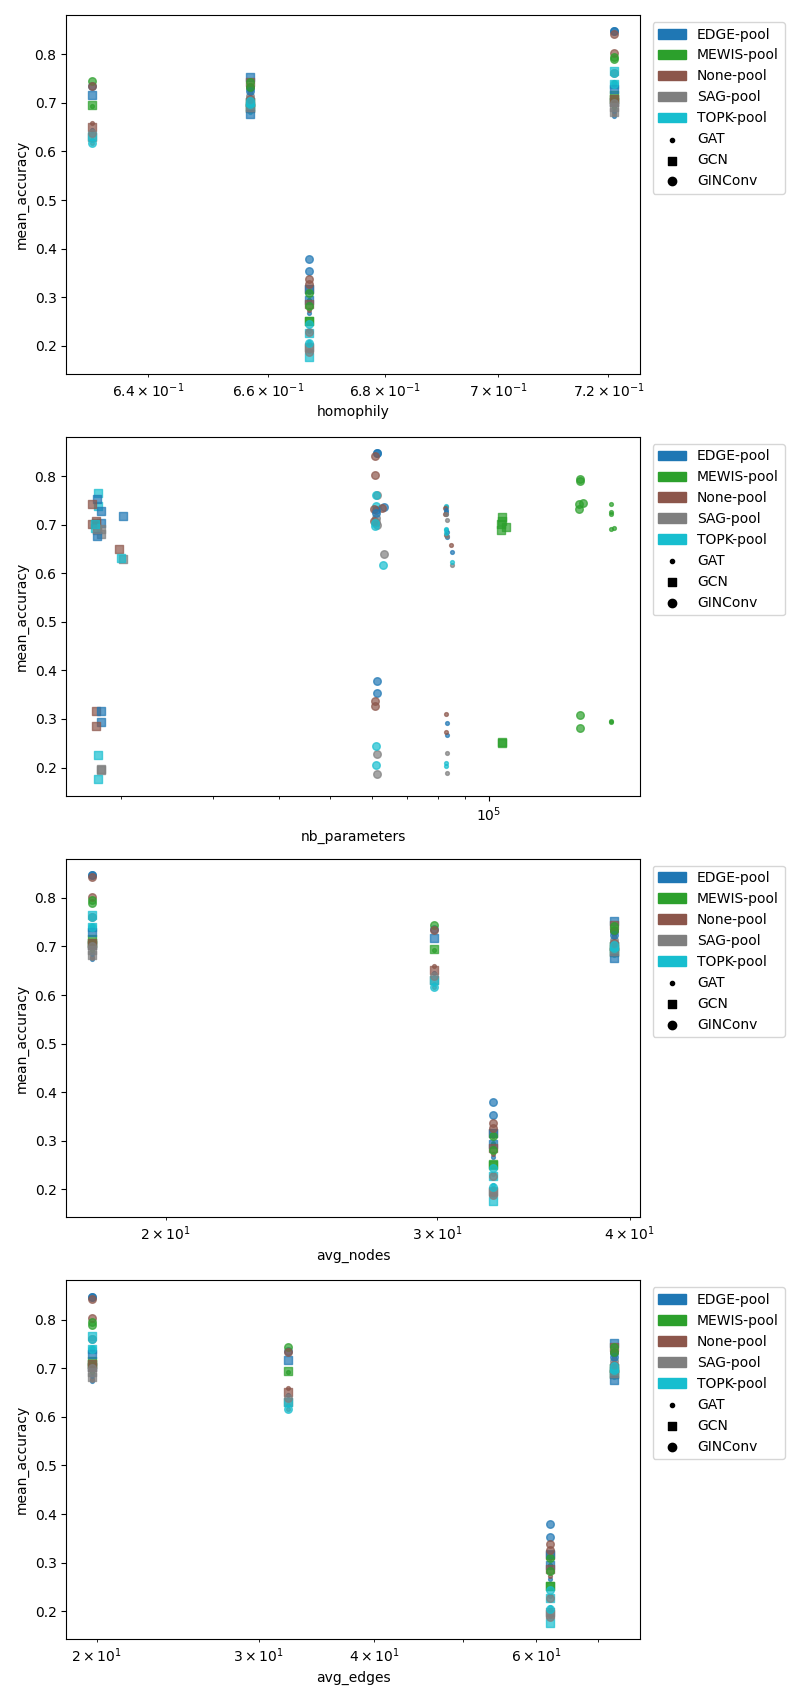

In [5]:
vplot.pairplot_from_dict(
                   [
                       ('homophily','mean_accuracy'),
                       ('nb_parameters','mean_accuracy'),
                       ('avg_nodes', 'mean_accuracy'),
                       ('avg_edges', 'mean_accuracy')
                    ],
                   dim_grid_subplots=(4,1),
                   figsize=(8,17),
                   plot=False,
                   kwargs1={'alpha' : .7, 's' : 30.},
                   kwargs2={'bbox_to_anchor' : (1.01,1)},
                   kwargs3={'alpha' : .7, 'linestyle' : ':', 'linewidth' : .7},
                   )

## 3) Barplot

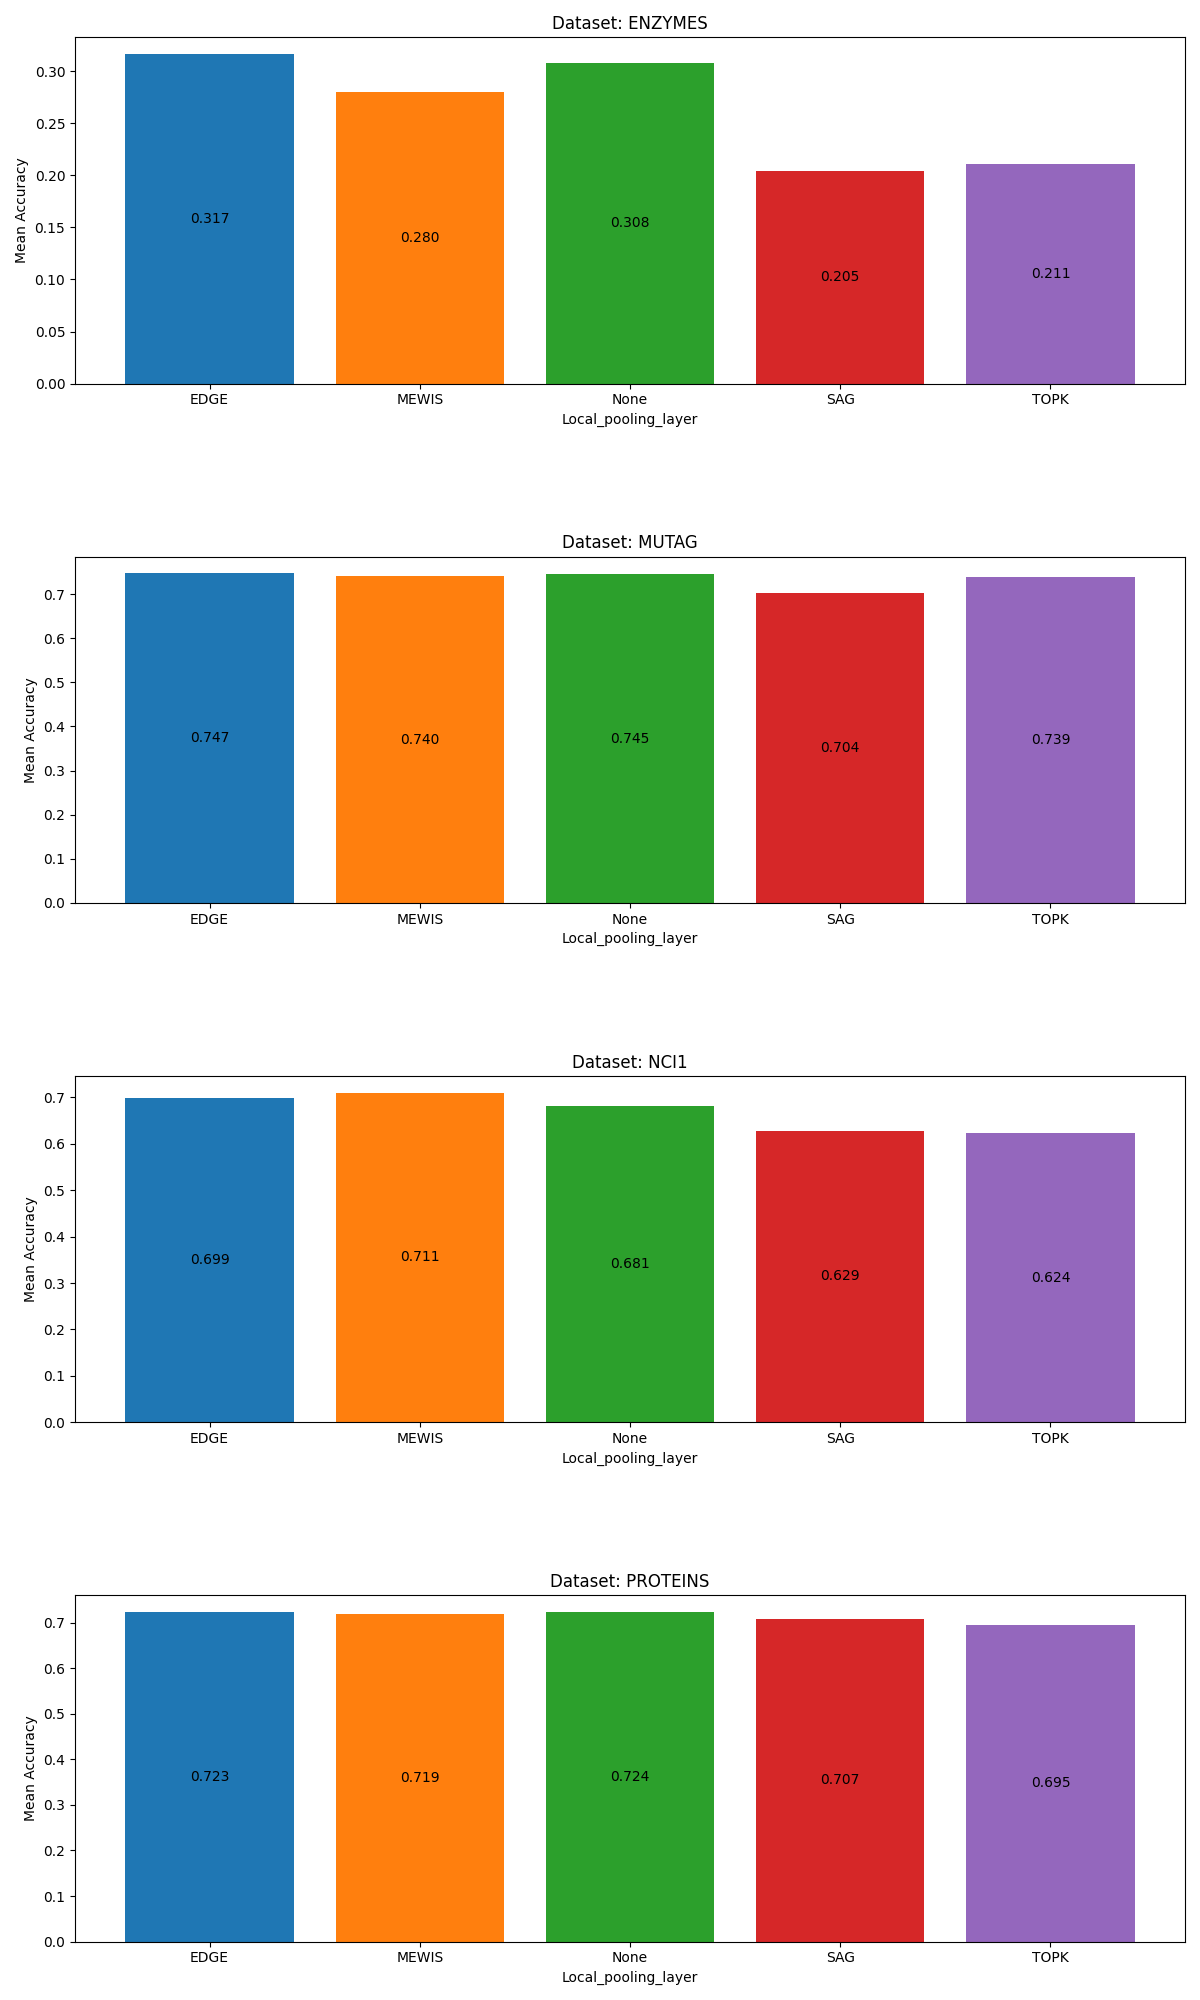

In [5]:
vplot.plot_bar_dataset(groupby="local_pooling_layer",
                       stack=None,
                       bar_width=0.12,
                       x_figsize=12);

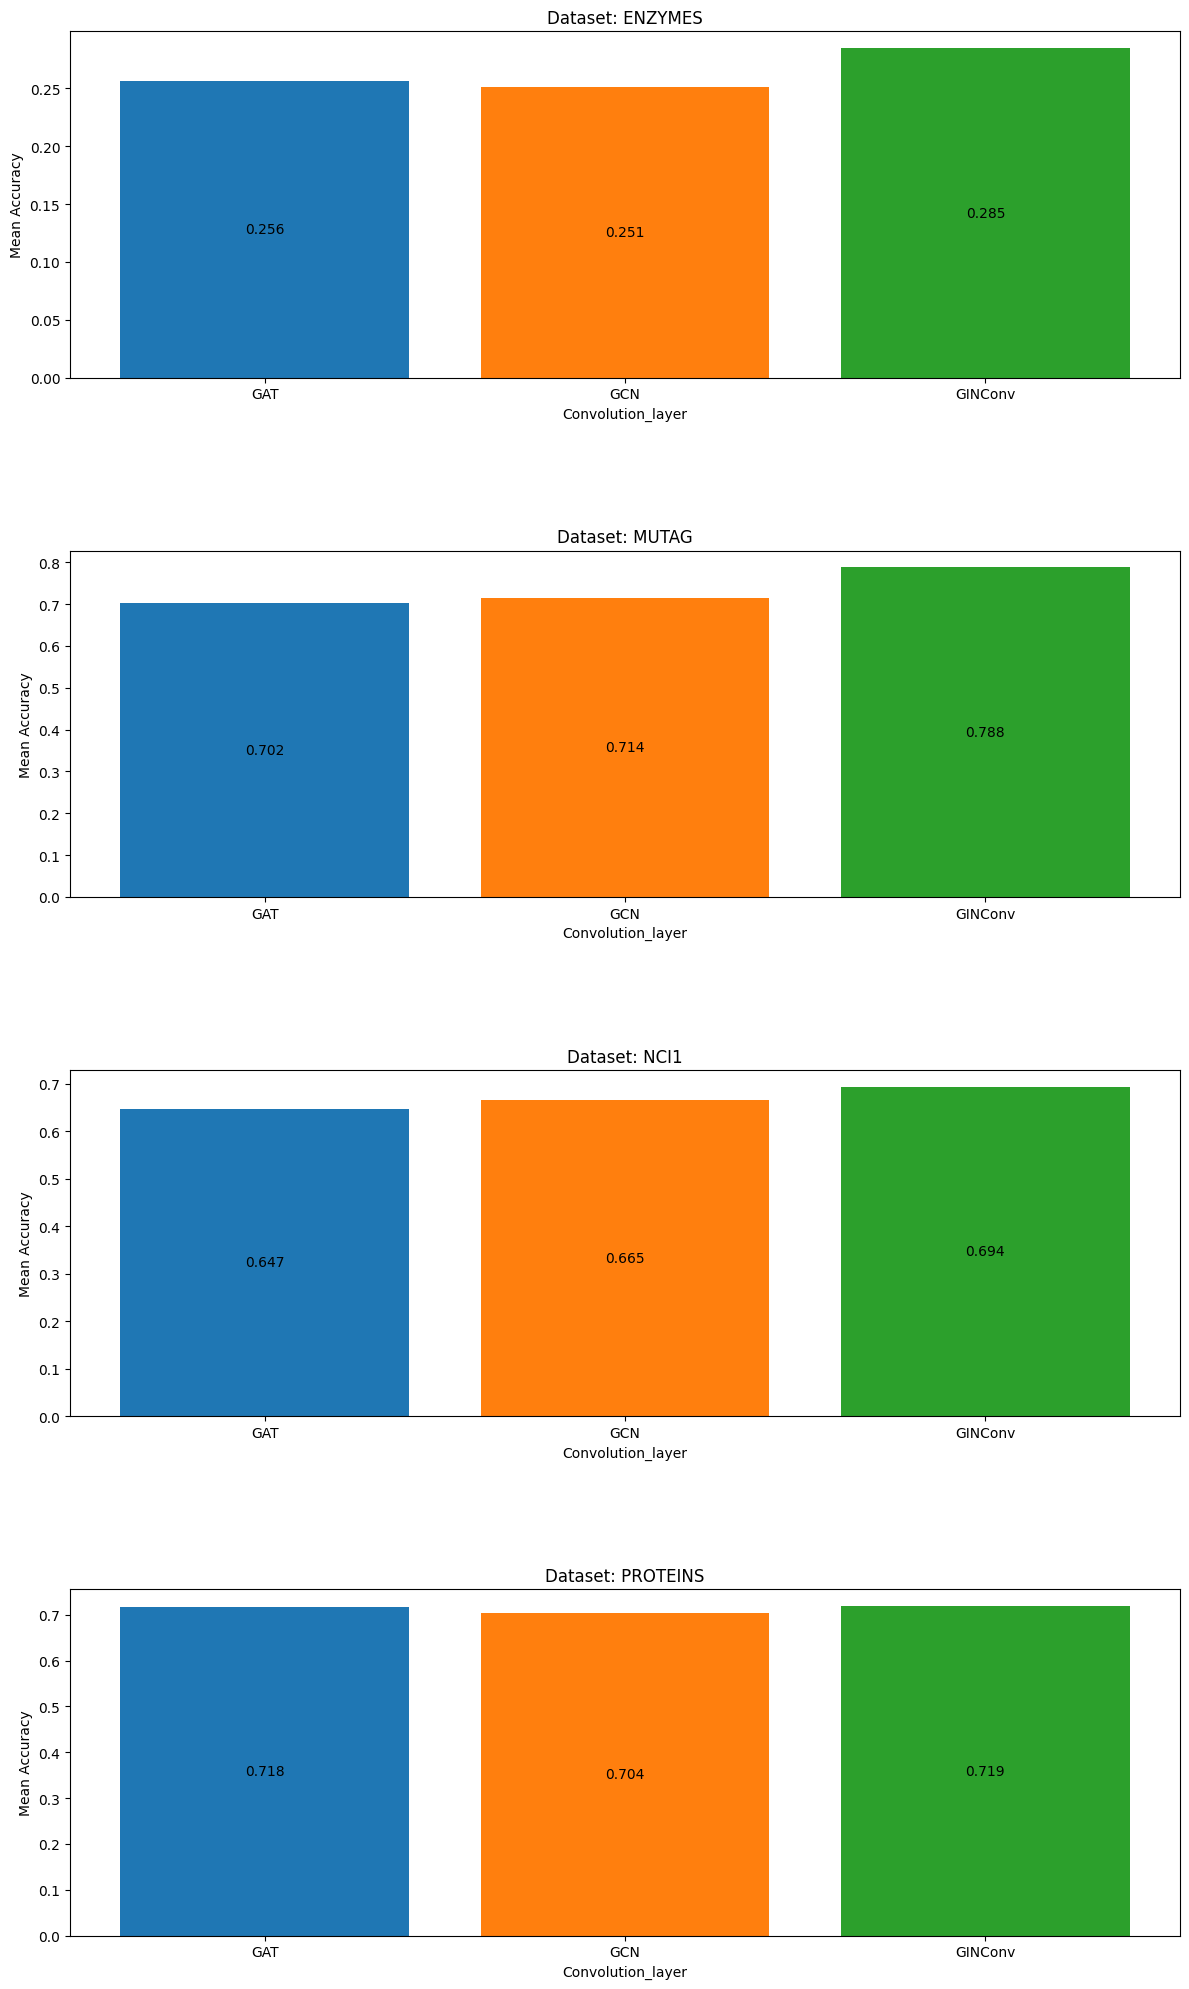

In [5]:
vplot.plot_bar_dataset(groupby="convolution_layer",
                       stack=None,
                       bar_width=0.4,
                       x_figsize=12);

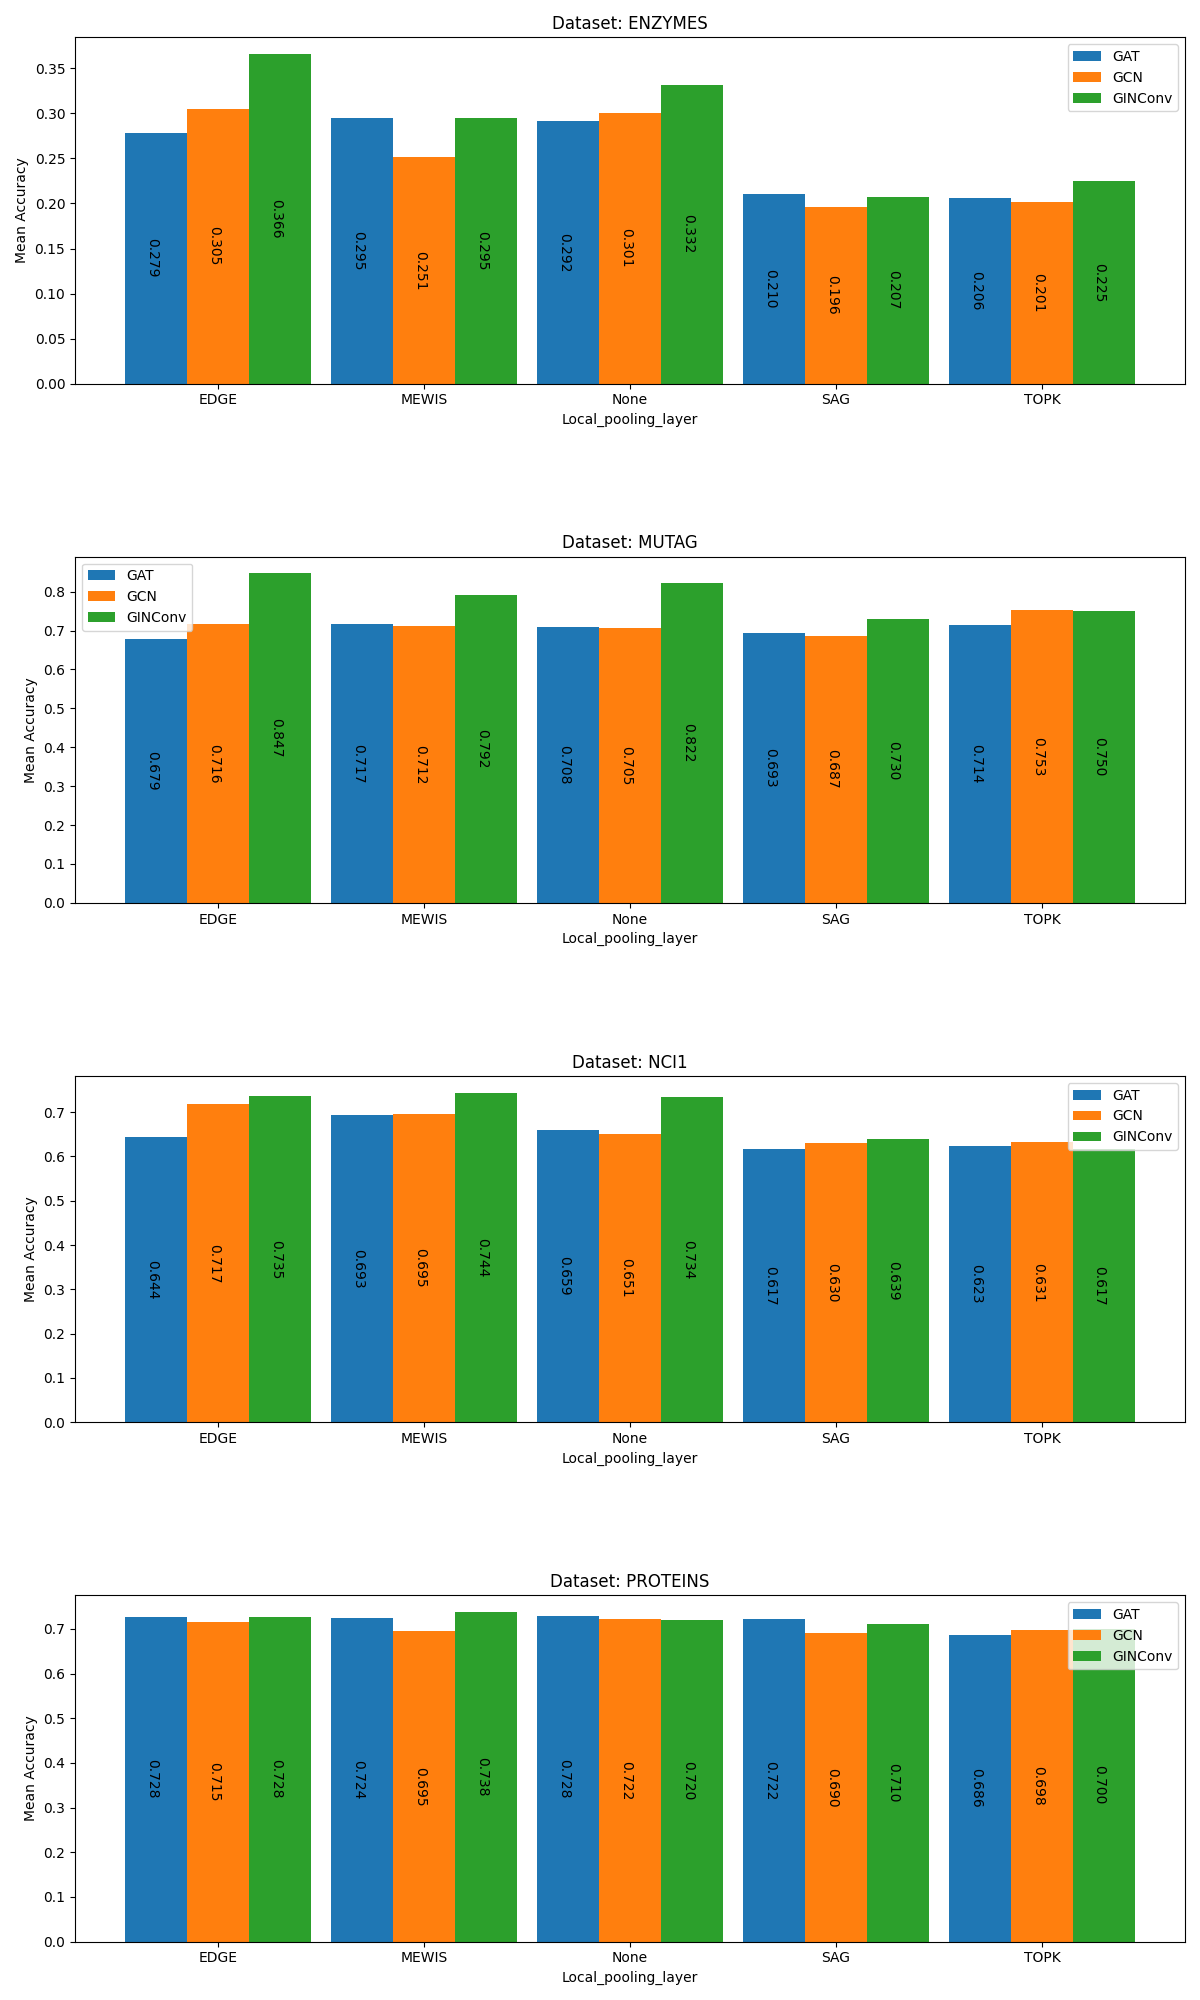

In [7]:
vplot.plot_bar_dataset(groupby="local_pooling_layer",
                       stack="convolution_layer",
                       bar_width=0.3,
                       offset = .02,
                       x_figsize=12);

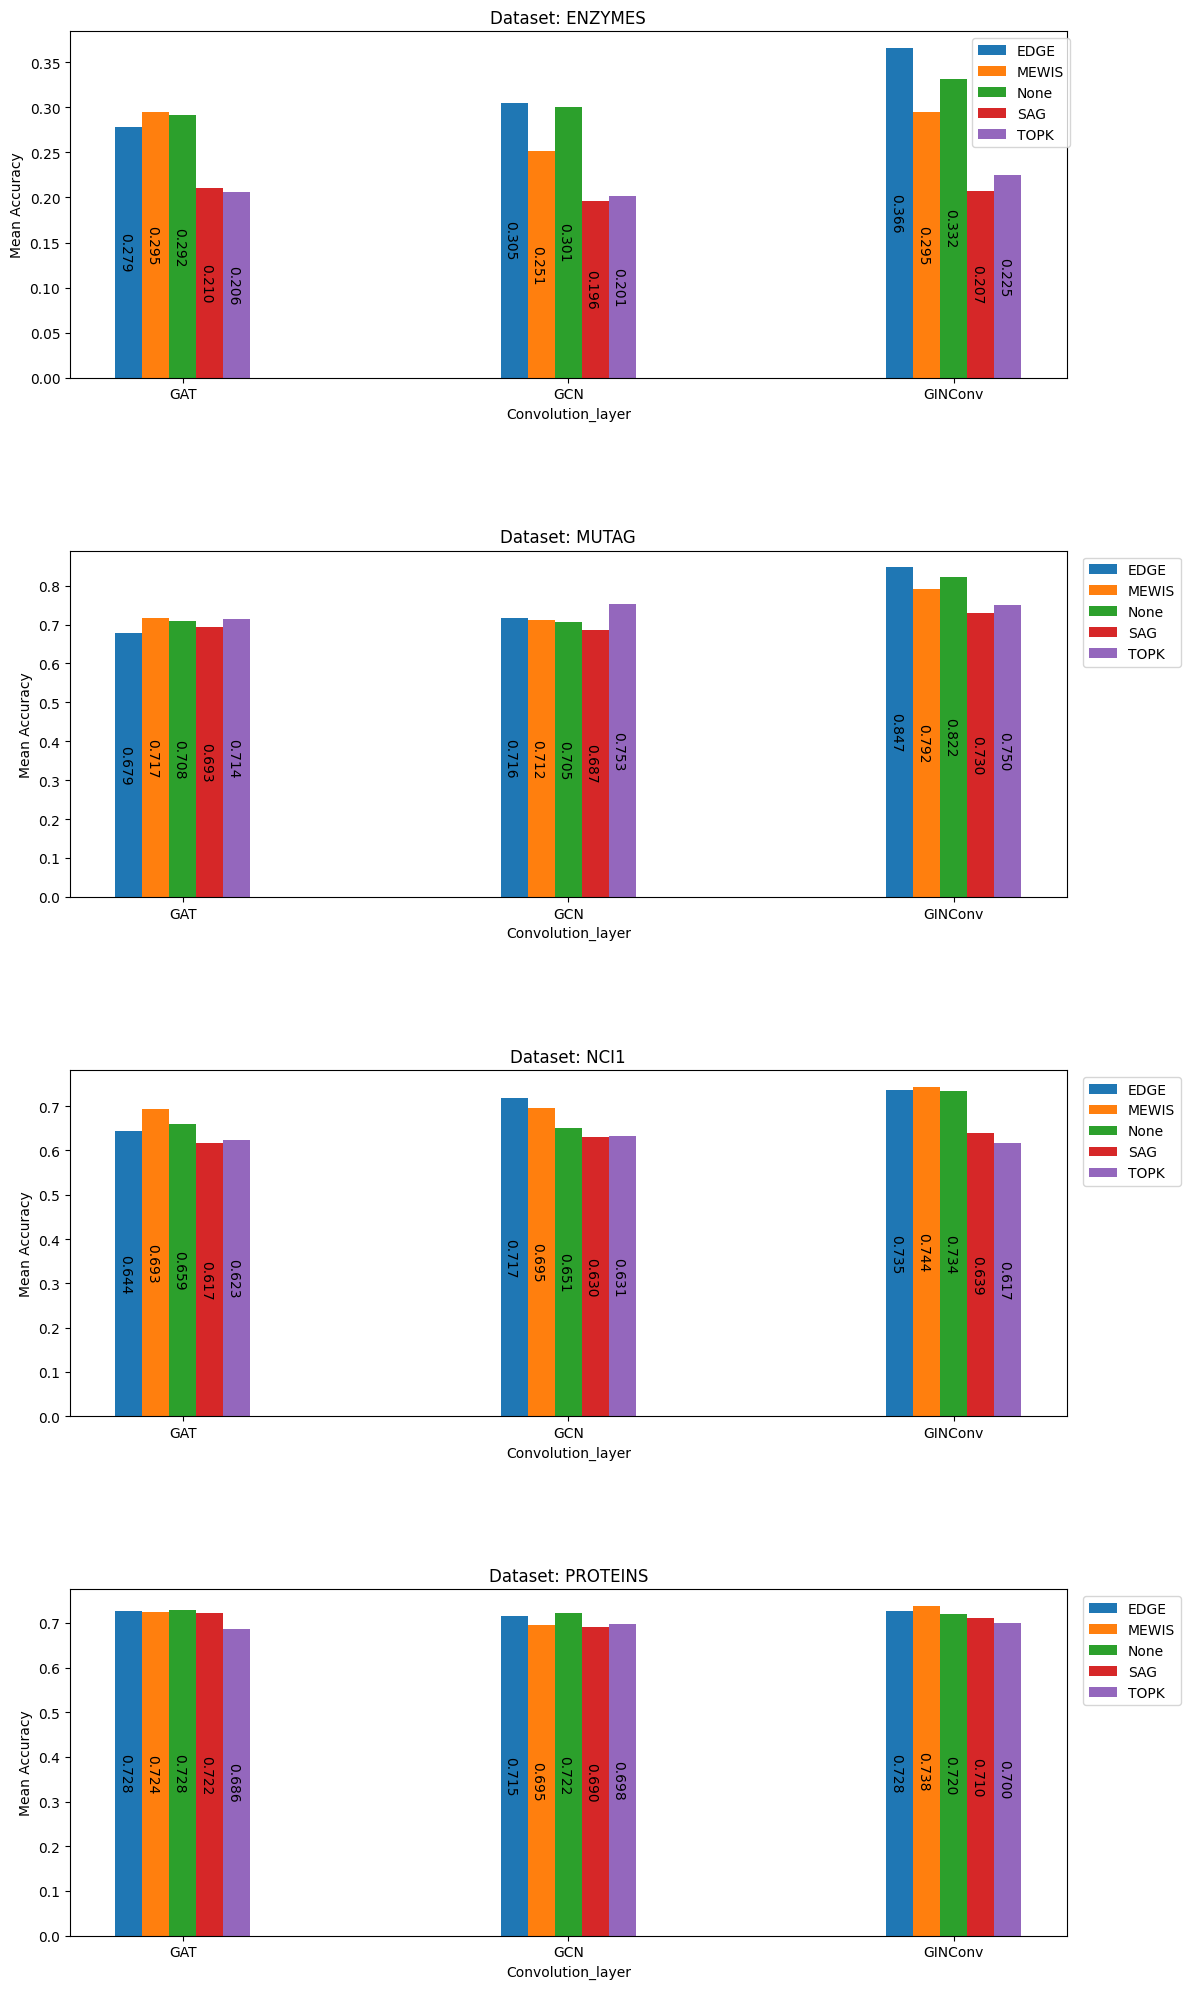

In [6]:
vplot.plot_bar_dataset(groupby="convolution_layer",
                       stack="local_pooling_layer",
                       bar_width=0.07,
                       offset=0.01,
                       x_figsize=12,
                       kwargs2={'bbox_to_anchor' : (1.01,1)});

# II Losses

In [6]:
plot = save_plot.Plot(list_dict)

In [7]:
plot.plot_all(train=True)

In [8]:
plot.plot_all(train=False)

# III Table 

In [3]:
table = to_table.ToTable(list_dict, per_dataset=False)

dict_keys(['dataset', 'global_pooling_layer', 'local_pooling_layer', 'convolution_layer', 'mean_accuracy', 'std_accuracy', 'training_time'])
Index(['dataset', 'global_pooling_layer', 'local_pooling_layer',
       'convolution_layer', 'mean_accuracy', 'std_accuracy', 'training_time'],
      dtype='object')


ValueError: invalid literal for int() with base 10: 'EDGE'

In [ ]:
table.save_all()

In [ ]:
df, \
df_best_architecture, \
df_worst_architecture, \
average_ranking_df_archi, \
df_by_architecture, \
df_best_pooling, \
df_worst_pooling, \
average_ranking_df_pooling, \
df_by_pooling = table.get_all(list_dict, per_dataset=False)

In [5]:
average_ranking_df_pooling

Dataset,ENZYMES,MUTAG,PROTEINS
Local,,,
EDGE,7,15,11
MEWIS,12,13,13
None,8,14,10
SAG,25,21,19
TOPK,23,12,23


In [6]:
average_ranking_df_archi

Dataset,ENZYMES,MUTAG,PROTEINS
Conv,,,
GAT,16,21,14
GCN,17,17,20
GINConv,12,7,12


In [7]:
df_best_architecture

Dataset,ENZYMES,MUTAG,PROTEINS
Local,,,
EDGE,GINConv,GINConv,GCN
MEWIS,GINConv,GINConv,GINConv
None,GINConv,GINConv,GCN
SAG,GAT,GINConv,GAT
TOPK,GINConv,GCN,GINConv


In [8]:
df_worst_architecture

Dataset,ENZYMES,MUTAG,PROTEINS
Local,,,
EDGE,GAT,GAT,GCN
MEWIS,GCN,GAT,GCN
None,GAT,GAT,GCN
SAG,GINConv,GAT,GCN
TOPK,GCN,GAT,GAT


In [9]:
df_best_pooling

Dataset,ENZYMES,MUTAG,PROTEINS
Conv,,,
GAT,None,MEWIS,None
GCN,EDGE,TOPK,EDGE
GINConv,EDGE,EDGE,MEWIS


In [10]:
df_worst_pooling

Dataset,ENZYMES,MUTAG,PROTEINS
Conv,,,
GAT,SAG,EDGE,TOPK
GCN,TOPK,SAG,EDGE
GINConv,SAG,SAG,TOPK


In [11]:
df_by_architecture

ENZYMES                 MUTAG  \
Conv    Local Global                                               
GAT     MEWIS max          $0.295\pm0.040$       $0.742\pm0.086$   
        None  max          $0.310\pm0.053$       $0.679\pm0.087$   
GCN     EDGE  max          $0.294\pm0.026$       $0.703\pm0.081$   
              mean         $0.317\pm0.052$       $0.729\pm0.065$   
        TOPK  mean         $0.227\pm0.023$       $0.766\pm0.078$   
GINConv EDGE  max          $0.353\pm0.039$  $\bm{0.847\pm0.063}$   
              mean    $\bm{0.379\pm0.047}$       $0.847\pm0.070$   
        MEWIS max          $0.309\pm0.055$       $0.789\pm0.077$   

                                  PROTEINS Training Time  
Conv    Local Global                                      
GAT     MEWIS max          $0.722\pm0.022$          1783  
        None  max          $0.734\pm0.027$            59  
GCN     EDGE  max     $\bm{0.753\pm0.024}$           722  
              mean         $0.676\pm0.016$           793  
        TOPK  mean         $0.701\pm0.034$            33  
GINConv EDGE  max          $0.731\pm0.017$           694  
              mean         $0.724\pm0.016$           775  
        MEWIS max          $0.743\pm0.016$          1804

In [12]:
df_by_pooling.sort_index()

ENZYMES                 MUTAG  \
Local Global Conv                                                  
EDGE  max    GCN           $0.294\pm0.026$       $0.703\pm0.081$   
             GINConv       $0.353\pm0.039$  $\bm{0.847\pm0.063}$   
      mean   GINConv  $\bm{0.379\pm0.047}$       $0.847\pm0.070$   
MEWIS max    GINConv       $0.309\pm0.055$       $0.789\pm0.077$   
      mean   GINConv       $0.282\pm0.040$       $0.795\pm0.067$   
None  max    GCN           $0.316\pm0.044$       $0.703\pm0.065$   
      mean   GINConv       $0.337\pm0.047$       $0.842\pm0.073$   
SAG   max    GAT           $0.189\pm0.025$       $0.676\pm0.062$   
             GINConv       $0.188\pm0.040$       $0.761\pm0.081$   
      mean   GAT           $0.231\pm0.037$       $0.711\pm0.117$   
TOPK  mean   GCN           $0.227\pm0.023$       $0.766\pm0.078$   
             GINConv       $0.244\pm0.065$       $0.739\pm0.067$   

                                  PROTEINS Training Time  
Local Global Conv                                         
EDGE  max    GCN      $\bm{0.753\pm0.024}$           722  
             GINConv       $0.731\pm0.017$           694  
      mean   GINConv       $0.724\pm0.016$           775  
MEWIS max    GINConv       $0.743\pm0.016$          1804  
      mean   GINConv       $0.733\pm0.020$          1605  
None  max    GCN           $0.743\pm0.029$            29  
      mean   GINConv       $0.708\pm0.020$            31  
SAG   max    GAT           $0.722\pm0.050$            64  
             GINConv       $0.714\pm0.039$            35  
      mean   GAT           $0.721\pm0.022$            71  
TOPK  mean   GCN           $0.701\pm0.034$            33  
             GINConv       $0.704\pm0.038$            37